### Notebooks : Latitudes and longitudes covered by the drifters over a time period
#### Goals : Estimate the distance (in x and y) covered by drifters over a time period and how this could impact the other diags that have been previously computed (correlation, energy spectra).
#### References : No references for now

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima
import matplotlib as mpl

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.sim_drifter as sdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster


In [4]:
client

Client Scheduler: tcp://10.148.1.74:47652 Dashboard: http://10.148.1.74:8787/status,Cluster Workers: 56 Cores: 56 Memory: 240.24 GB


In [5]:
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [6]:
dr = sdr.drifter_dataframe(root_path+run, tdir_max=1)

In [7]:
# Definition parameters
t0 = 1550 #initial time
t1 = 1590 # final time
tmid = (t0+t1)/2 # mid period
flt_id = 225 # test drifter id

#### Functions to compute initial, final, maximal and minimal latitudes for each drifters over a period of time

In [8]:
def time_window_processing(df, myfun, columns, T, N, overlap=0.5):
    ''' break each drifter time series into time windows and process each windows
    
    Parameters
    ----------
        
        df: Dataframe
            This dataframe represents a drifter time series
        
        T: float
            Length of the time windows
            
        myfun
            Method that will be applied to each window
            
        columns: list of str
            List of columns of df that will become inputs of myfun
            
        N: int
            Length of myfun outputs
            
        overlap: float
            Amount of overlap between windows. 
            Should be between 0 and 1. 
            Default is 0.5
            
        **myfun_kwargs
            Keyword arguments for myfun
    
    '''
    try:
        dr_id = df.id.unique()[0]
    except:
        dr_id = df.name
    p = df.sort_values('time').set_index('time')
    tmin, tmax = p.index[0], p.index[-1]
    myfun_args = tmin,tmax
    # need to create an empty dataframe, in case the loop below is empty
    myfun_out = myfun(None,N,*list(myfun_args)) # get index from fake output
    index = ['x','y']+['id']+list(myfun_out.index)
    out = [pd.DataFrame({_:[] for _ in index})]
    t=tmin
    while t+T<=tmax:
        #
        _p = p.loc[t:t+T]
        t0,t1 = _p.index.min(),_p.index.max()
        myfun_kwargs=t0,t1
        # compute average position
        x, y = sdr.mean_position(_p, L)
        # apply myfun
        myfun_out = myfun(_p, N, *list(myfun_args))
        # combine with mean position and time
        _out = pd.DataFrame([[x, y]+[df.id.unique()[0]]+list(myfun_out)],
                            columns = index,
                            index = [t+T/2.])
        out.append(_out)
        t+=T*(1-overlap)
    return pd.concat(out)

In [9]:
def latitudes_processing(df, myfun,N, tmin,tmax):
    ''' Compute maximal, minimal, initial and final latitudes for each drfiters over a period of time
    
    Parameters
    ----------
        
        df: Dataframe
            This dataframe represents a drifter time series
        
        myfun : func
            Method that will be applied to each window
            
        tmin : float
            initial time of the time window to observe
        tmax : float
            final time of the time window to observe
    Returns
    ----------
        out : pandas dataframe
            dataframe with maximal, minimal, initial and final latitudes over a period of time (with the drifters id in index)
    
    '''
    try:
        dr_id = df.id.unique()[0]
    except:
        dr_id = df.name
    p = df.sort_values('time').set_index('time')
    _p = p.loc[tmin:tmax]
    if _p.size==0:
        out = pd.DataFrame(data = np.full((1,4),np.nan),
                           columns=['latmax','latmin','lat0','lat1'],
                           index=p.id.unique())
    else:
    # need to create an empty dataframe, in case the loop below is empty
    #latmax,latmin,lat0,lat1 = myfun(_p) # get index from fake output
        myfun_out = myfun(_p,N,_p.index.min(),_p.index.max())
        index = list(myfun_out.index)
        out = pd.DataFrame(data = [list(myfun_out)],
                           columns=index,
                           index=_p.id.unique())#{'latmax':[myfun_out[0]],'latmin':[myfun_out[1]],'lati':[myfun_out[2]],'latf':[myfun_out[3]]},index = df.id.unique())
#[list(myfun_out)])
    return out

def diags_dist(flt,N,t0,t1):
#    fltI = flt.sel(time=slice(Ti,Tf))
    if flt is None:
        return pd.Series(np.random.randn(N),index=['latmax','latmin','lat0','lat1','dx','dy','ds'])
    else : 
        dxint = np.diff(np.unwrap(flt.x)).sum()
        dyint = np.diff(flt.y).sum()
        dsint = np.sqrt(np.diff(np.unwrap(flt.x))**2+np.diff(flt.y)**2).sum()
        return pd.Series([flt.y.max(),flt.y.min(),flt.y.iloc[0],flt.y.iloc[-1],dxint,dyint,dsint],
                         index=['latmax','latmin','lat0','lat1','dx','dy','ds'])#,fltI.v

#### test the function for one drifter (flt_id)

In [10]:
df0 = dr.df.groupby('id').get_group(flt_id).compute()

In [115]:
#out = latitudes_processing(df0, diags_dist, t0,t1)
L=1026
out = time_window_processing(df0, diags_dist,['latmax','latmin','lat0','lat1'],50,7)
out

,x,y,id,latmax,latmin,lat0,lat1,dx,dy,ds
1525.0069,997.738510,1967.312692,225.0,2041.41528,1923.55908,1950.46532,1923.55908,61.892160,-26.90624,835.504269
1550.0069,78.294877,1975.325408,225.0,2041.41528,1887.29012,1964.87852,1948.11456,404.967788,-16.76396,990.044683


#### Apply the function to each drifter : 

In [11]:
L=1026
df_chunked = dr.df.groupby('id').apply(time_window_processing, diags_dist, 
                                       ['latmax','latmin','lat0','lat1'],40,7
                                      )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
df_chunked.get_partition(0).compute()

x            y      id      latmax      latmin  \
id                                                                        
22   1510.0069  111.220082   820.643731    22.0   883.82940   728.43076   
     1520.0069  121.384007   852.922447    22.0   883.82940   793.89724   
     1530.0069   92.183922   814.074864    22.0   876.62320   781.34072   
     1540.0069   83.128593   841.068939    22.0   949.00856   781.34072   
     1550.0069  109.590473   915.955326    22.0   959.21428   820.47644   
...                    ...          ...     ...         ...         ...   
8503 1540.0069  773.300155  1319.016472  8503.0  1436.46076  1222.53008   
     1550.0069   33.615855  1323.962432  8503.0  1455.09600  1256.46324   
     1560.0069  134.450006  1376.517990  8503.0  1455.09600  1292.84392   
     1570.0069   53.024335  1393.058551  8503.0  1453.74848  1293.87352   
     1580.0069  973.706463  1374.973514  8503.0  1453.74848  1308.34612   

                      lat0        lat1  
id                                      
22   1510.0069   728.43076   728.44956  
     1520.0069   832.17004   832.20148  
     1530.0069   876.62320   876.60736  
     1540.0069   793.89724   793.84732  
     1550.0069   820.47644   820.55368  
...                    ...         ...  
8503 1540.0069  1222.53008  1222.90276  
     1550.0069  1295.62980  1295.45716  
     1560.0069  1339.57884  1339.92128  
     1570.0069  1293.87352  1293.94624  
     1580.0069  1452.06144  1452.12640  

[203 rows x 7 columns]

In [12]:
# Defintiion of initial bins
y_bins = np.arange(0,2800,50)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y0_cut'] = df_chunked['lat0'].map_partitions(pd.cut, bins=y_bins)

In [13]:
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )

In [17]:
df_chunked.get_partition(0).compute()

,time,x,y,id,latmax,latmin,lat0,lat1,dx,dy,ds,y0_cut
id,,,,,,,,,,,,
22,1520.0069,101.675810,817.349010,22.0,883.82940,728.43076,728.43076,820.47644,22.453864,92.04568,444.006600,"(700, 750]"
22,1540.0069,100.896920,865.022826,22.0,959.21428,781.34072,876.62320,900.05296,-6.366404,23.42976,475.384278,"(850, 900]"
22,1560.0069,109.099909,884.196421,22.0,959.21428,820.47644,820.47644,899.41928,52.639172,78.94284,508.343826,"(800, 850]"
135,1520.0069,289.289554,1499.019048,135.0,1675.07408,1225.11608,1408.82080,1435.22288,383.741764,26.40208,2265.066255,"(1400, 1450]"
135,1540.0069,431.659281,1465.496558,135.0,1724.19324,1225.11608,1650.61980,1625.59488,1336.459876,-25.02492,3519.183555,"(1650, 1700]"
...,...,...,...,...,...,...,...,...,...,...,...,...
8454,1540.0069,318.766541,991.796817,8454.0,1083.18244,874.73792,1014.57576,874.73792,316.084488,-139.83784,759.857158,"(1000, 1050]"
8454,1560.0069,442.285897,977.955194,8454.0,1083.18244,867.42188,1043.76192,948.83040,229.996712,-94.93152,712.247668,"(1000, 1050]"
8503,1520.0069,916.201967,1295.119755,8503.0,1542.33064,1145.59784,1216.02460,1295.62980,846.610500,79.60520,1607.180174,"(1200, 1250]"


In [14]:
# difference btw mat max and min
df_chunked['minmax_diff'] = df_chunked['latmax']-df_chunked['latmin']
# ratio initial lat/ final lat
df_chunked['if_r'] = df_chunked['lat0']/df_chunked['lat1']


In [15]:
DF = df_chunked.compute()

In [16]:
ds = DF.set_index(DF.y0_cut.map(lambda v: v.mid)).drop(columns=['time','x','y']).rename(columns={'y0_cut':'y0_bins'}).to_xarray()
ds

<xarray.Dataset>
Dimensions:      (y0_cut: 26395)
Coordinates:
  * y0_cut       (y0_cut) float64 725.0 875.0 825.0 ... 1.825e+03 1.675e+03
Data variables:
    id           (y0_cut) float64 22.0 22.0 22.0 ... 8.308e+03 8.308e+03
    latmax       (y0_cut) float64 883.8 959.2 959.2 ... 1.804e+03 1.691e+03
    latmin       (y0_cut) float64 728.4 781.3 820.5 ... 1.433e+03 1.433e+03
    lat0         (y0_cut) float64 728.4 876.6 820.5 ... 1.804e+03 1.651e+03
    lat1         (y0_cut) float64 820.5 900.1 899.4 ... 1.478e+03 1.691e+03
    dx           (y0_cut) float64 22.45 -6.366 52.64 ... -59.86 -74.24 96.26
    dy           (y0_cut) float64 92.05 23.43 78.94 26.4 ... -197.6 -326.3 40.33
    ds           (y0_cut) float64 444.0 475.4 508.3 ... 578.9 864.2 1.018e+03
    y0_bins      (y0_cut) object (700, 750] (850, 900] ... (1650, 1700]
    minmax_diff  (y0_cut) float64 155.4 177.9 138.7 450.0 ... 208.1 370.9 257.8
    if_r         (y0_cut) float64 0.8878 0.974 0.9122 ... 1.12 1.221 0.9761

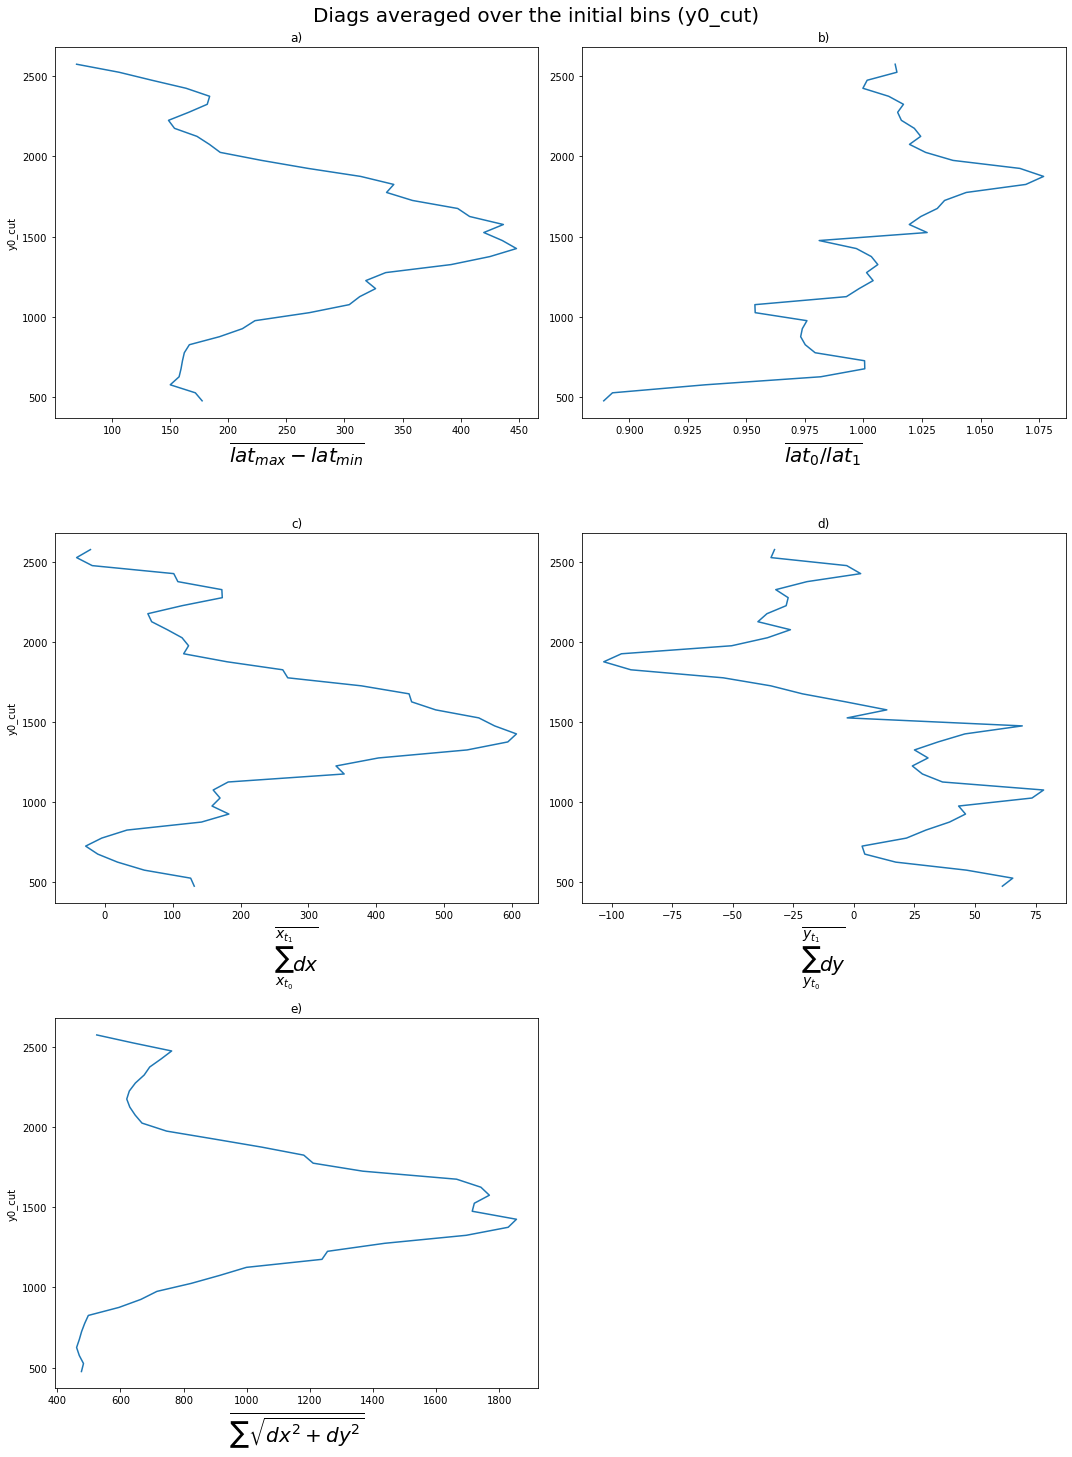

In [18]:
fig = plt.figure(figsize=(15,20))
fig.suptitle('Diags averaged over the initial bins (y0_cut)',x=0.5,y=1.01,fontsize=20)
ax = fig.add_subplot(3,2,1)
ds.groupby('y0_cut').mean().minmax_diff.plot(y='y0_cut',ax=ax)
ax.set_xlabel(r'$\overline{lat_{max}-lat_{min}}$',fontsize=20)
ax.set_title('a)')
ax = fig.add_subplot(3,2,2)
ds.groupby('y0_cut').mean().if_r.plot(y='y0_cut',ax=ax)
ax.set_xlabel(r'$\overline{lat_{0}/lat_{1}}$',fontsize=20);ax.set_ylabel('')
ax.set_title('b)')
ax = fig.add_subplot(3,2,3)
ds.groupby('y0_cut').mean().dx.plot(y='y0_cut')
ax.set_xlabel(r'$\overline{\sum_{x_{t_0}}^{x_{t_1}}dx}$',fontsize=20)
ax.set_title('c)')
ax = fig.add_subplot(3,2,4)
ds.groupby('y0_cut').mean().dy.plot(y='y0_cut')
ax.set_xlabel(r'$\overline{\sum_{y_{t_0}}^{y_{t_1}}dy}$',fontsize=20);ax.set_ylabel('')
ax.set_title('d)')
ax = fig.add_subplot(3,2,5)
ds.groupby('y0_cut').mean().ds.plot(y='y0_cut')
ax.set_xlabel(r'$\overline{\sum \sqrt{dx^2+dy^2}}$',fontsize=20)
ax.set_title('e)')
plt.tight_layout()


### Comments:
a) The largest difference (>450km) between maximal and minimal latitudes are found in initial bins in the jet ; smaller differencies being found far south (<1000km) and north (>2000km) from the jet.\
b) Slight northward tendency (lat1>lat0) for low and mid latitudes ($\sim$<1600km). Southward tendency for higher latitudes with a peak around 1900km (lat1$\simeq$1.075lat0). Overall, the ratio lat0/lat1 stays within the range [0.950 ; 1.075]\
c) Large distance covered in the jet in the x axis (this was expected). The motion is eastward which is also expected (the contrary would have been quite disturbing)\
d) Southward tendency north of the jet and northward tendency south of the jet (this is quite logicial because of the northern and southern boundaries). Near the northern boundary of the jet drifter seem attracted southward (toward the jet). In the jet, the motions in y are small compared to those in x ($\sim$50km vs hundreds of km).\
e) Large motions in and near the jet

#### Latitudes extrema for each drifter over 40 days (time window used to compute energy spectra in previous work)

Text(0, 0.5, '$lat_{max}-lat_{min}$')

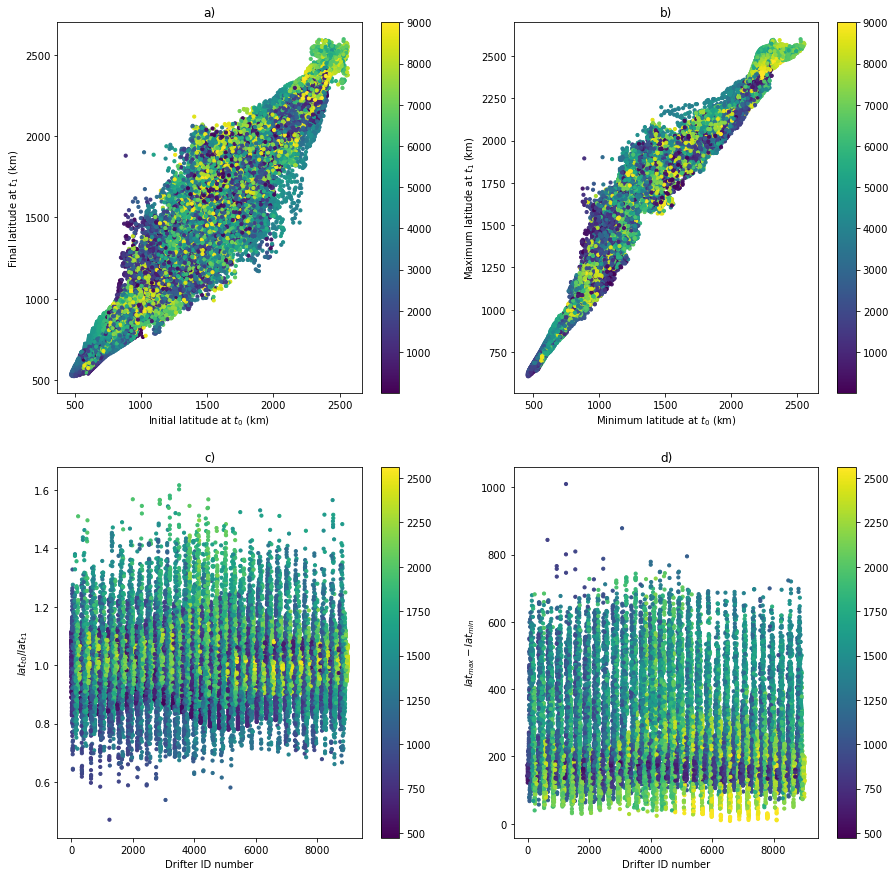

In [68]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2,2,1)
cs = xr.plot.scatter(ds,'lat0','lat1',s=10,c=ds.id,ax=ax)
ax.set_xlabel('Initial latitude at $t_0$ (km)');ax.set_ylabel('Final latitude at $t_1$ (km)')
ax.set_title('a)')
plt.colorbar(cs)
ax = fig.add_subplot(2,2,2)
cs = xr.plot.scatter(ds,'latmin','latmax',s=10,c=ds.id,ax=ax)
ax.set_title('b)')
plt.colorbar(cs)
ax.set_xlabel('Minimum latitude at $t_0$ (km)');ax.set_ylabel('Maximum latitude at $t_1$ (km)')
ax = fig.add_subplot(2,2,3)
cs = xr.plot.scatter(ds,'id','if_r',s=10,c=ds.lat0,ax=ax)
plt.colorbar(cs)
ax.set_title('c)')
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$lat_{t0}/lat_{t1}$')
ax = fig.add_subplot(2,2,4)
cs = xr.plot.scatter(ds,'id','minmax_diff',s=10,c=ds.lat0,ax=ax)
plt.colorbar(cs)
ax.set_title('d)')
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$lat_{max}-lat_{min}$')

#### Comments : 
c) We observe the values closer to 1.(within the [0.8;1.2] range) to correspond to low (<1000km) or high (>2000km) initial latitudes.The values lower than 1 seem to correspond mainly low initial latitudes. Those obsevations are coherent with the previous observations.\
d) We find that during this time period the drifter can move a lot between their maximum and minimum latitudes depending on their initial latitude.\
At low initial latitudes (<1000km), the difference btw latmax and latmin stays around 150 km.\
At high latitudes (>2000km), we find more differences with diff from 0 to $\sim$200km for lat0>2400km and larger differences ($\sim$400km) for some drifters nearer of 2000km.\
Between 1000 and 2000 km the difference range from near 0 to over 600km.

In [72]:
# Definition of regions : 
y1 = 1150
y2 = 1950
def drifters_regions(ds, y1,y2):
    id1 = ds.where(ds.lat0<=y1,drop=True).id.values
    id3 = ds.where(ds.lat0>y2,drop=True).id.values
    id2 = ds.id[np.isin(ds.id,id1)==False]
    id2 = id2[np.isin(id2,id3)==False]
    id11 = ds.where(ds.lat1<=y1,drop=True).id.values
    id13 = ds.where(ds.lat1>y2,drop=True).id.values
    id12 = ds.id[np.isin(ds.id,id11)==False]
    id12 = id12[np.isin(id12,id13)==False]
    return [id1,id2,id3],[id11,id12,id13]
id0_40,id1_40 = drifters_regions(ds, y1,y2) 
print([s.size for s in id0_40])
print([s.size for s in id1_40])

[8207, 8589, 6692]
[8173, 8511, 6683]


In [73]:
print('Number of drifters south of the jet at t0 : ',id0_40[0].size)
print('Number of drifters north of the jet at t0 : ',id0_40[2].size)
print('Number of drifters in and near the jet at t0 : ',id0_40[1].size)
print('Number of drifters south of the jet at t1 : ',id1_40[0].size)
print('Number of drifters north of the jet at t1 : ',id1_40[2].size)
print('Number of drifters in and near the jet at t1 : ',id1_40[1].size)

Number of drifters south of the jet at t0 :  8207
Number of drifters north of the jet at t0 :  6692
Number of drifters in and near the jet at t0 :  8589
Number of drifters south of the jet at t1 :  8173
Number of drifters north of the jet at t1 :  6683
Number of drifters in and near the jet at t1 :  8511


In [74]:
print('Region 1 : South ; ', 'Region 2 : In and near the jet ; ', 'Region 3 : North the jet')
print('Number of drifters that left region 1 : ',id0_40[0][np.isin(id0_40[0],id1_40[0])==False].size)
print('Number of drifters that left region 2 : ',id0_40[1][np.isin(id0_40[1],id1_40[1])==False].size)
print('Number of drifters that left region 3 : ',id0_40[2][np.isin(id0_40[2],id1_40[2])==False].size)
print('Number of drifters that left region 1 for region 2 : ',id0_40[0][np.isin(id0_40[0],id1_40[1])==True].size)
print('Number of drifters that left region 2 for region 1 : ',id0_40[1][np.isin(id0_40[1],id1_40[0])==True].size)
print('Number of drifters that left region 2 for region 3 : ',id0_40[1][np.isin(id0_40[1],id1_40[2])==True].size)
print('Number of drifters that left region 3  for region 2 : ',id0_40[2][np.isin(id0_40[2],id1_40[1])==True].size)

Region 1 : South ;  Region 2 : In and near the jet ;  Region 3 : North the jet
Number of drifters that left region 1 :  454
Number of drifters that left region 2 :  1903
Number of drifters that left region 3 :  392
Number of drifters that left region 1 for region 2 :  454
Number of drifters that left region 2 for region 1 :  829
Number of drifters that left region 2 for region 3 :  1074
Number of drifters that left region 3  for region 2 :  392


#### Comments :
In this part we seek to quantify a tendency depending on the initial area. For this we define 3 regions : south, in and near the jet and north).\
First thing is that only a small part of the drifters leave their initial regions over a 40 days period.\
Most of the change is observe in region 2 with approximatly 1/5 of the drifters leaving the area. The turbulent jet seems to be an area where the drifters don't remain for long time periods. We can also note the northward tendency.\
Finally, the total number of drifters by area reamins almost unchanged.

#### Same than previously but over T=100 days

In [23]:
df_chunked = dr.df.groupby('id').apply(time_window_processing, diags_dist, 
                                       ['latmax','latmin','lat0','lat1'],90,7
                                      )
# Defintion of initial bins
y_bins = np.arange(0,2800,50)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y0_cut'] = df_chunked['lat0'].map_partitions(pd.cut, bins=y_bins)

df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  


In [24]:
# difference btw mat max and min
df_chunked['minmax_diff'] = df_chunked['latmax']-df_chunked['latmin']
# ratio initial lat/ final lat
df_chunked['if_r'] = df_chunked['lat0']/df_chunked['lat1']

In [25]:
DF = df_chunked.compute()

In [34]:
ds100 = DF.set_index(DF.y0_cut.map(lambda v: v.mid)).drop(columns=['time','x','y']).rename(columns={'y0_cut':'y0_bins'}).to_xarray()
ds100

<xarray.Dataset>
Dimensions:      (y0_cut: 8675)
Coordinates:
  * y0_cut       (y0_cut) float64 725.0 1.425e+03 ... 1.675e+03 1.825e+03
Data variables:
    id           (y0_cut) float64 22.0 135.0 553.0 ... 8.281e+03 8.308e+03
    latmax       (y0_cut) float64 959.2 1.724e+03 ... 1.988e+03 1.858e+03
    latmin       (y0_cut) float64 728.4 1.225e+03 ... 1.441e+03 1.433e+03
    lat0         (y0_cut) float64 728.4 1.409e+03 ... 1.686e+03 1.848e+03
    lat1         (y0_cut) float64 955.5 1.411e+03 ... 1.987e+03 1.82e+03
    dx           (y0_cut) float64 171.0 1.086e+03 88.38 ... 249.4 29.69 103.4
    dy           (y0_cut) float64 227.1 2.245 37.85 84.8 ... 179.9 301.6 -27.68
    ds           (y0_cut) float64 1.091e+03 5.118e+03 ... 1.968e+03 1.817e+03
    y0_bins      (y0_cut) object (700, 750] (1400, 1450] ... (1800, 1850]
    minmax_diff  (y0_cut) float64 230.8 499.1 147.2 637.6 ... 490.9 546.7 425.1
    if_r         (y0_cut) float64 0.7624 0.9984 0.9825 ... 0.8901 0.8482 1.015

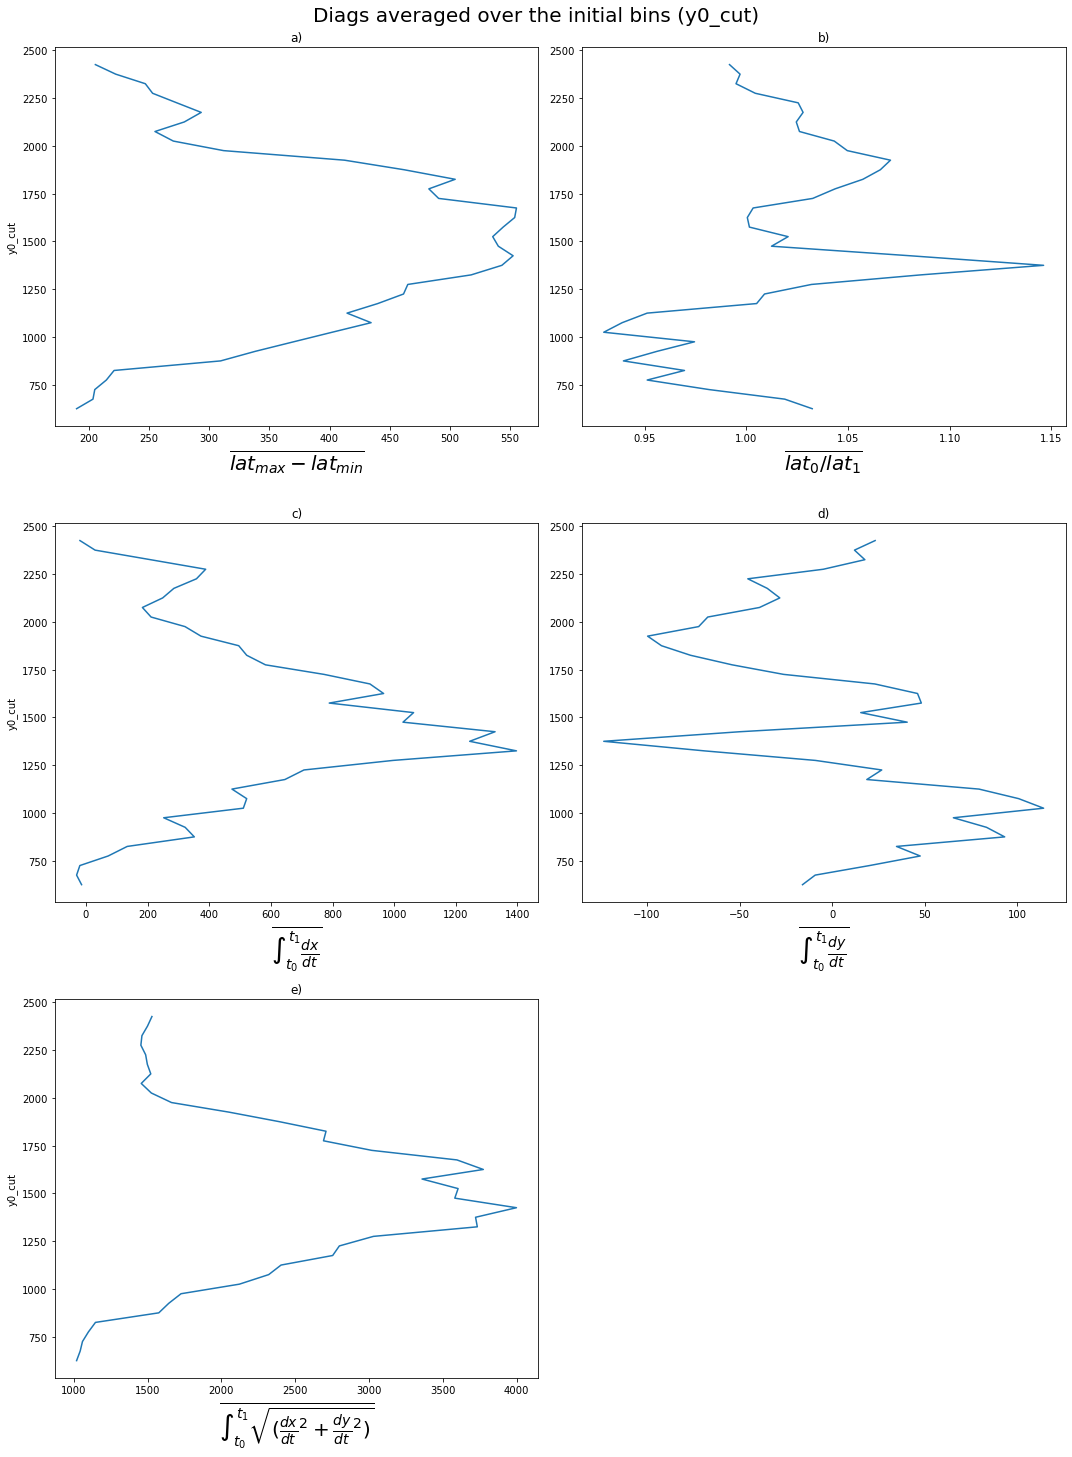

In [27]:
fig = plt.figure(figsize=(15,20))
fig.suptitle('Diags averaged over the initial bins (y0_cut)',x=0.5,y=1.01,fontsize=20)
ax = fig.add_subplot(3,2,1)
ds.groupby('y0_cut').mean().minmax_diff.plot(y='y0_cut',ax=ax)
ax.set_xlabel(r'$\overline{lat_{max}-lat_{min}}$',fontsize=20)
ax.set_title('a)')
ax = fig.add_subplot(3,2,2)
ds.groupby('y0_cut').mean().if_r.plot(y='y0_cut',ax=ax)
ax.set_xlabel(r'$\overline{lat_{0}/lat_{1}}$',fontsize=20);ax.set_ylabel('')
ax.set_title('b)')
ax = fig.add_subplot(3,2,3)
ds.groupby('y0_cut').mean().dx.plot(y='y0_cut')
ax.set_xlabel(r'$\overline{\int_{t_0}^{t_1}\frac{dx}{dt}}$',fontsize=20)
ax.set_title('c)')
ax = fig.add_subplot(3,2,4)
ds.groupby('y0_cut').mean().dy.plot(y='y0_cut')
ax.set_xlabel(r'$\overline{\int_{t_0}^{t_1}\frac{dy}{dt}}$',fontsize=20);ax.set_ylabel('')
ax.set_title('d)')
ax = fig.add_subplot(3,2,5)
ds.groupby('y0_cut').mean().ds.plot(y='y0_cut')
ax.set_xlabel(r'$\overline{\int_{t_0}^{t_1}\sqrt{(\frac{dx}{dt}^2+\frac{dy}{dt}^2)}}$',fontsize=20)
ax.set_title('e)')
plt.tight_layout()


Text(0, 0.5, '$lat_{max}-lat_{min}$')

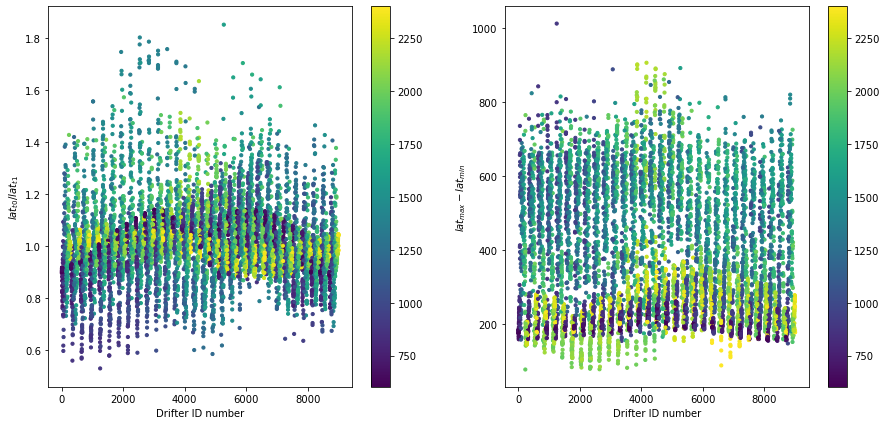

In [28]:
fig = plt.figure(figsize=(15,7))
#ax = fig.add_subplot(2,2,1)
#cs = xr.plot.scatter(ds,'lat0','lat1',s=10,c=ds100.id,ax=ax)
#ax.set_xlabel('Initial latitude at $t_0$ (km)');ax.set_ylabel('Final latitude at $t_1$ (km)')
#plt.colorbar(cs)
#ax = fig.add_subplot(2,2,2)
#cs = xr.plot.scatter(ds100,'latmin','latmax',s=10,c=ds100.id,ax=ax)
#plt.colorbar(cs)
#ax.set_xlabel('Minimum latitude at $t_0$ (km)');ax.set_ylabel('Maximum latitude at $t_1$ (km)')
ax = fig.add_subplot(1,2,1)
cs = xr.plot.scatter(ds100,'id','if_r',s=10,c=ds100.lat0,ax=ax)
plt.colorbar(cs)
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$lat_{t0}/lat_{t1}$')
ax = fig.add_subplot(1,2,2)
cs = xr.plot.scatter(ds100,'id','minmax_diff',s=10,c=ds100.lat0,ax=ax)
plt.colorbar(cs)
ax.set_xlabel('Drifter ID number');ax.set_ylabel(r'$lat_{max}-lat_{min}$')


#### Comments:
For the longest time window (100 days), we still find than most of drifters move between close latitudes extrema at high latitudes (>2000km). At the lowest latitudes, the gap between min and max lat seem to increase for longer periods and the drifters seem to move further away from their initial position. Overall we observe more variations in latitudes extream and a growing number of drifters going significantly away from their starting latitude. More drifter from high latitudes are also moving southward from their lat0.\

###  The cells after this are just test and parts that could useful in the future but present on their own no interest.
### Number of drifters in (30x30) bins at t0

In [ ]:
dr.init_bins(y={'min':0, 'max': 2800, 'step': 30}, x={'min':0, 'max': 1000, 'step': 30})

In [10]:
df0 = dr.df.groupby('time').get_group(t0).compute()

In [15]:
df1 = dr.df.groupby('time').get_group(t1).compute()

In [17]:
flt0 = df0.sort_values('id').set_index('id')
flt1 = df1.sort_values('id').set_index('id')

In [28]:
count_bins0 = df0.groupby(['x_cut','y_cut'])['id'].agg('count').rename({'id': 'id_count'}).to_xarray()

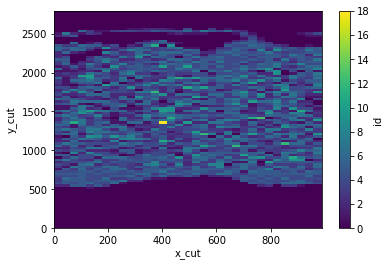

In [31]:
count_bins0.plot(y='y_cut')

### This part contains tests used in the previous part,this is just visualization of different trajectories and informations on those trajectories.

In [9]:
# tests on one drifter
flt1 = dr.df.groupby('id').get_group(flt_id).compute().sort_values('time').set_index('time')

In [10]:
# Informations on drifter trajectory:
flti = flt1.loc[t0:t1]
latmin,latmax, lat0,lat1, latmid = flti.y.min(),flti.y.max(), flt1.loc[t0].y, flt1.loc[t1].y, flt1.loc[tmid].y
#print('Minimum latitude : ',latmin,';  Maximum latitude : ',latmax,';  Latitude at t0 : ', lat0,
#      ';  Laitude at t1 : ', lat1';  Latitude at tmid : ',latmid)

#### Plot of latitude maximum, minimum and at mid period of one drifter

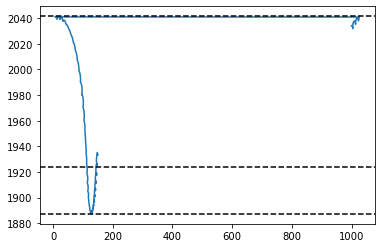

In [11]:
fig,ax  = plt.subplots()
ax.plot(flti.x,flti.y)
ax.axhline(y=latmax,c='k',linestyle='--')
ax.axhline(y=latmin,c='k',linestyle='--')
ax.axhline(y=latmid,c='k',linestyle='--')

#### Definition of the drifters postions at t0

In [13]:
df0 = dr.df.groupby('time').get_group(t0).compute().sort_values('y').set_index('y')

In [31]:
dr.init_bins(y={'min':0, 'max': 2800, 'step': 30}, x={'min':0, 'max': 1000, 'step': 30},
             time={'min':0, 'max': 1000, 'step': 1})

In [ ]:
dr.df.groupby(['id'])['y'].agg(['mean','min','max']).compute()#.loc[t0:t1]

In [ ]:
# Distance between inital drifter position (x0,y0) and position at time t (x,y)
def distance(x,y,x0,y0):
    return np.sqrt((x-x0)**2+(y-y0)**2)

In [ ]:
plt.plot(distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum())
distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum().shape

In [11]:
df0 = dr.df.groupby('time').get_group(flt1.index.min()).compute().sort_values('y').set_index('y')
#id0 = dr.df.groupby('time').get_group(flt1.index.min()).id

In [12]:
lat = [725,1215,1515,1715,2100]

In [13]:
DF0 = df0.to_xarray()#.sel(y=lat,method='nearest')

In [21]:
#DF0.sel(y=0,method='nearest')
yi = DF0.y[10::1800]
idi = DF0.id[10::1800]

In [ ]:
# Get several drifters
ds = {}
for i in idi[:2]:
    ds['flt_%s'%int(i.values)] = dr.df.groupby('id').get_group(int(i.values)).compute().sort_values('time').set_index('time').to_xarray()
ds

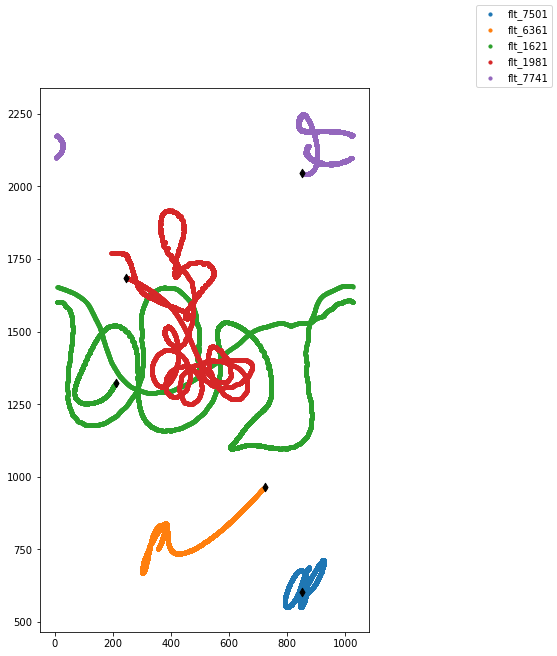

In [153]:
#Plot several drifters trajectories 
#(illustration of different trajectories depending on the initial latitude)
ti, tf = 1500,1600
fig,ax = plt.subplots(figsize=(10,10))
for d in ds :
    ax.scatter(ds['%s'%d].x.sel(time=slice(ti,tf)),ds['%s'%d].y.sel(time=slice(ti,tf)),
               s=10,label=str(d))
    ax.scatter(ds['%s'%d].x[0],ds['%s'%d].y[0],c='k',marker='d')
ax.set_aspect('equal')
fig.legend()

In [148]:
#Compute the latitudes for the chosen drifter(s) and wrap function to plot latitude max and min (dashed lines)
#and initial position (red point) (left figure) and dy/dt (v) (right figure)
def diags_dist(flt,Ti,Tf):
    fltI = flt.sel(time=slice(Ti,Tf))
    return fltI.y.max().values,fltI.y.min().values,fltI.y[0].values,fltI.y[-1].values,fltI.v
def plot_dist(flt,Ti,Tf,figsize):
    fltI = flt.sel(time=slice(Ti,Tf))
    latmax,latmin, lat0,lat1, dydt = diags_dist(flt,Ti,Tf)
    fig = plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,2,1)
    ax.plot(fltI.x,fltI.y)
    ax.axhline(y=latmax,c='k',linestyle='--')
    ax.axhline(y=latmin,c='k',linestyle='--')
    ax.scatter(fltI.x[0],fltI.y[0],c='r')
    ax.set_ylabel(r'${y_\rho}$ (km)');ax.set_xlabel(r'${x_\rho}$ (km)')
    ax = fig.add_subplot(1,2,2)
    ax.plot(fltI.time,dydt)
    ax.set_ylabel('dy/dt');ax.set_xlabel('Time (days)')

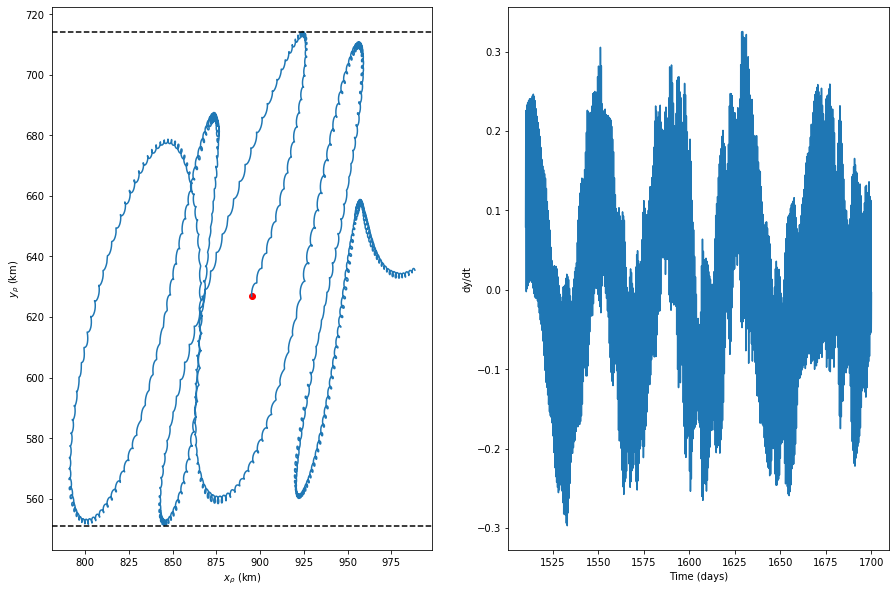

In [154]:
plot_dist(ds['flt_7501'],1510,1700,(15,10))

In [17]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
